In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/DC Unet/images_with_masks.zip' -d '/content/drive/MyDrive/DC Unet'

Archive:  /content/drive/MyDrive/DC Unet/images_with_masks.zip
replace /content/drive/MyDrive/DC Unet/maskableonly_1folder_less/imagess/case1 (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/DC Unet/maskableonly_1folder_less/imagess/case1 (1).jpg  
  inflating: /content/drive/MyDrive/DC Unet/maskableonly_1folder_less/imagess/case1 (10).jpg  
  inflating: /content/drive/MyDrive/DC Unet/maskableonly_1folder_less/imagess/case1 (100).jpg  
  inflating: /content/drive/MyDrive/DC Unet/maskableonly_1folder_less/imagess/case1 (101).jpg  
  inflating: /content/drive/MyDrive/DC Unet/maskableonly_1folder_less/imagess/case1 (102).jpg  
  inflating: /content/drive/MyDrive/DC Unet/maskableonly_1folder_less/imagess/case1 (103).jpg  
  inflating: /content/drive/MyDrive/DC Unet/maskableonly_1folder_less/imagess/case1 (104).jpg  
  inflating: /content/drive/MyDrive/DC Unet/maskableonly_1folder_less/imagess/case1 (105).jpg  
  inflating: /content/drive/MyDrive/DC Unet/

In [ ]:
!ls '/content/drive/MyDrive/DC Unet/maskableonly_1folder_less/maskss' | wc -l

1284


In [ ]:
%cd '/content/drive/MyDrive/DC Unet'

/content/drive/MyDrive/DC Unet


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras import initializers
from keras.layers import SpatialDropout2D,Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate,AveragePooling2D, UpSampling2D, BatchNormalization, Activation, add,Dropout,Permute,ZeroPadding2D,Add, Reshape
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU, ReLU, PReLU
from keras.utils.vis_utils import plot_model
from keras import backend as K 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras import applications, optimizers, callbacks
import matplotlib
import keras
import tensorflow as tf
from keras.layers import *

def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers
    
    Arguments:
        x {keras layer} -- input layer 
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters
    
    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})
    
    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def DCBlock(U, inp, alpha = 1.67):
    '''
    DC Block
    
    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    #shortcut = inp

    #shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
   #                      int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3_1 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5_1 = conv2d_bn(conv3x3_1, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7_1 = conv2d_bn(conv5x5_1, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out1 = concatenate([conv3x3_1, conv5x5_1, conv7x7_1], axis=3)
    out1 = BatchNormalization(axis=3)(out1)
    
    conv3x3_2 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5_2 = conv2d_bn(conv3x3_2, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7_2 = conv2d_bn(conv5x5_2, int(W*0.5), 3, 3,
                        activation='relu', padding='same')
    out2 = concatenate([conv3x3_2, conv5x5_2, conv7x7_2], axis=3)
    out2 = BatchNormalization(axis=3)(out2)

    out = add([out1, out2])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out

def ResPath(filters, length, inp):
    '''
    ResPath
    
    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer 
    
    Returns:
        [keras layer] -- [output layer]
    '''

    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out

def DCUNet(height, width, channels):

    inputs = Input((height, width, channels))

    dcblock1 = DCBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(dcblock1)
    dcblock1 = ResPath(32, 4, dcblock1)

    dcblock2 = DCBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(dcblock2)
    dcblock2 = ResPath(32*2, 3, dcblock2)

    dcblock3 = DCBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(dcblock3)
    dcblock3 = ResPath(32*4, 2, dcblock3)

    dcblock4 = DCBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(dcblock4)
    dcblock4 = ResPath(32*8, 1, dcblock4)

    dcblock5 = DCBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(dcblock5), dcblock4], axis=3)
    dcblock6 = DCBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(dcblock6), dcblock3], axis=3)
    dcblock7 = DCBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(dcblock7), dcblock2], axis=3)
    dcblock8 = DCBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(dcblock8), dcblock1], axis=3)
    dcblock9 = DCBlock(32, up9)

    conv10 = conv2d_bn(dcblock9, 1, 1, 1, activation='sigmoid')
    
    model = Model(inputs=[inputs], outputs=[conv10])
    
    return model

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras import initializers
from keras.layers import SpatialDropout2D,Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate,AveragePooling2D, UpSampling2D, BatchNormalization, Activation, add,Dropout,Permute,ZeroPadding2D,Add, Reshape
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU, ReLU, PReLU
from keras.utils.vis_utils import plot_model
from keras import backend as K 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras import applications, optimizers, callbacks
import matplotlib
import keras
import tensorflow as tf
from keras.layers import *
from google.colab.patches import cv2_imshow

In [ ]:
X = []
Y = []

In [ ]:
folder_path = 'maskableonly_1folder_less/imagess'
for data_file in sorted(os.listdir(folder_path)):
  path = folder_path +'/'+ data_file
  # print(path)
  img = cv2.imread(path, 1)
  resized_img = cv2.resize(img, (256, 192), interpolation = cv2.INTER_CUBIC)

  X.append(resized_img)

In [ ]:
folder_path = 'maskableonly_1folder_less/maskss'
for data_file in sorted(os.listdir(folder_path)):
  path = folder_path +'/'+ data_file
  # print(path)
  img = cv2.imread(path, 0)
  resized_img = cv2.resize(img, (256, 192), interpolation = cv2.INTER_CUBIC)

  Y.append(resized_img)

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=5)
Y_train = Y_train.reshape((Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],1))
Y_test = Y_test.reshape((Y_test.shape[0],Y_test.shape[1],Y_test.shape[2],1))

In [ ]:
X_train = X_train / 255
X_test = X_test / 255
Y_train = Y_train / 255
Y_test = Y_test / 255

In [ ]:
Y_train = np.round(Y_train,0)	
Y_test = np.round(Y_test,0)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1027, 192, 256, 3)
(1027, 192, 256, 1)
(257, 192, 256, 3)
(257, 192, 256, 1)


In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 1.0  #0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union

In [ ]:
def dice_coef_loss(y_true,y_pred):
    return 1 - dice_coef(y_true,y_pred)

In [ ]:
def iou_loss(y_true,y_pred):
    return 1 - jacard(y_true, y_pred)

In [ ]:
def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.75
    smooth = 1
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

In [ ]:
def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [ ]:
def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [ ]:
def saveModel(model):

    model_json = model.to_json()

    try:
        os.makedirs('models')
    except:
        pass
    
    fp = open('models/modelP.json','w')
    fp.write(model_json)
    model.save('models/modelW.h5')
    model.save_weights('models/modelWeights.h5')

In [ ]:
def evaluateModel(model, X_test, Y_test, batchSize):
    
    try:
        os.makedirs('results')
    except:
        pass 
    
    yp = model.predict(x=X_test, batch_size=batchSize, verbose=1)
    yp = np.round(yp,0)
    
    for i in range(10):

        plt.figure(figsize=(20,10))
        plt.subplot(1,3,1)
        plt.imshow(X_test[i])
        plt.title('Input')
        plt.subplot(1,3,2)
        plt.imshow(Y_test[i].reshape(Y_test[i].shape[0],Y_test[i].shape[1]))
        plt.title('Ground Truth')
        plt.subplot(1,3,3)
        plt.imshow(yp[i].reshape(yp[i].shape[0],yp[i].shape[1]))
        plt.title('Prediction')

        intersection = yp[i].ravel() * Y_test[i].ravel()
        union = yp[i].ravel() + Y_test[i].ravel() - intersection

        jacard = (np.sum(intersection)/np.sum(union))  
        plt.suptitle('Jacard Index'+ str(np.sum(intersection)) +'/'+ str(np.sum(union)) +'='+str(jacard))

        plt.savefig('results/'+str(i)+'.png',format='png')
        plt.close()
    
    jacard = 0
    dice = 0
    
    
    for i in range(len(Y_test)):
        yp_2 = yp[i].ravel()
        y2 = Y_test[i].ravel()
        
        intersection = yp_2 * y2
        union = yp_2 + y2 - intersection

        jacard += (np.sum(intersection)/np.sum(union))  

        dice += (2. * np.sum(intersection) ) / (np.sum(yp_2) + np.sum(y2))

    
    jacard /= len(Y_test)
    dice /= len(Y_test)
    
    # print(len(Y_test))

    print('Jacard Index : '+str(jacard))
    print('Dice Coefficient : '+str(dice))
    

    fp = open('models/log.txt','a')
    fp.write(str(jacard)+'\n')
    fp.close()

    fp = open('models/best.txt','r')
    best = fp.read()
    fp.close()

    if(jacard>float(best)):
        print('*****************************************************************************************************************************')
        print('Jacard Index improved from '+str(best)+' to '+str(jacard))
        print('*****************************************************************************************************************************')
        fp = open('models/best.txt','w')
        fp.write(str(jacard))
        fp.close()

        saveModel(model)

In [ ]:
def trainStep(model, X_train, Y_train, X_test, Y_test, epochs, batchSize):

    
    for epoch in range(epochs):
        print('Epoch : {}'.format(epoch+1))
        model.fit(x=X_train, y=Y_train, batch_size=batchSize, epochs=1, verbose=1)     

        evaluateModel(model,X_test, Y_test,batchSize)

    return model 

In [ ]:
model = DCUNet(height=192, width=256, channels=3)

In [ ]:
model.compile(optimizer='adam', loss=focal_tversky, metrics=[dice_coef, jacard, 'accuracy'])

In [ ]:
model.summary()
saveModel(model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 256, 8)  216         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 192, 256, 8)  216         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 192, 256, 8)  24          conv2d[0][0]                     
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
fp = open('models/log.txt','w')
fp.close()
fp = open('models/best.txt','w')
fp.write('-1.0')
fp.close()

In [ ]:
trainStep(model, X_train, Y_train, X_test, Y_test, epochs = 100, batchSize = 8)

NameError: ignored

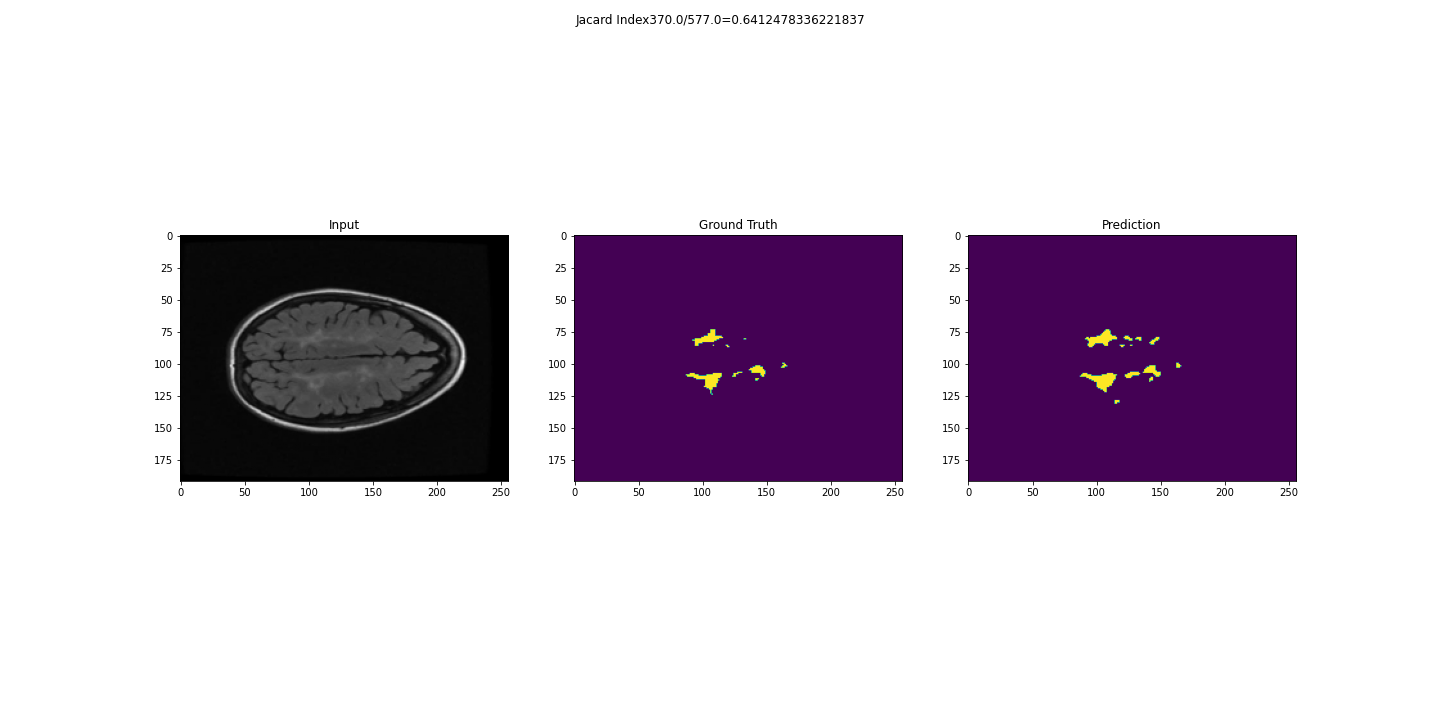

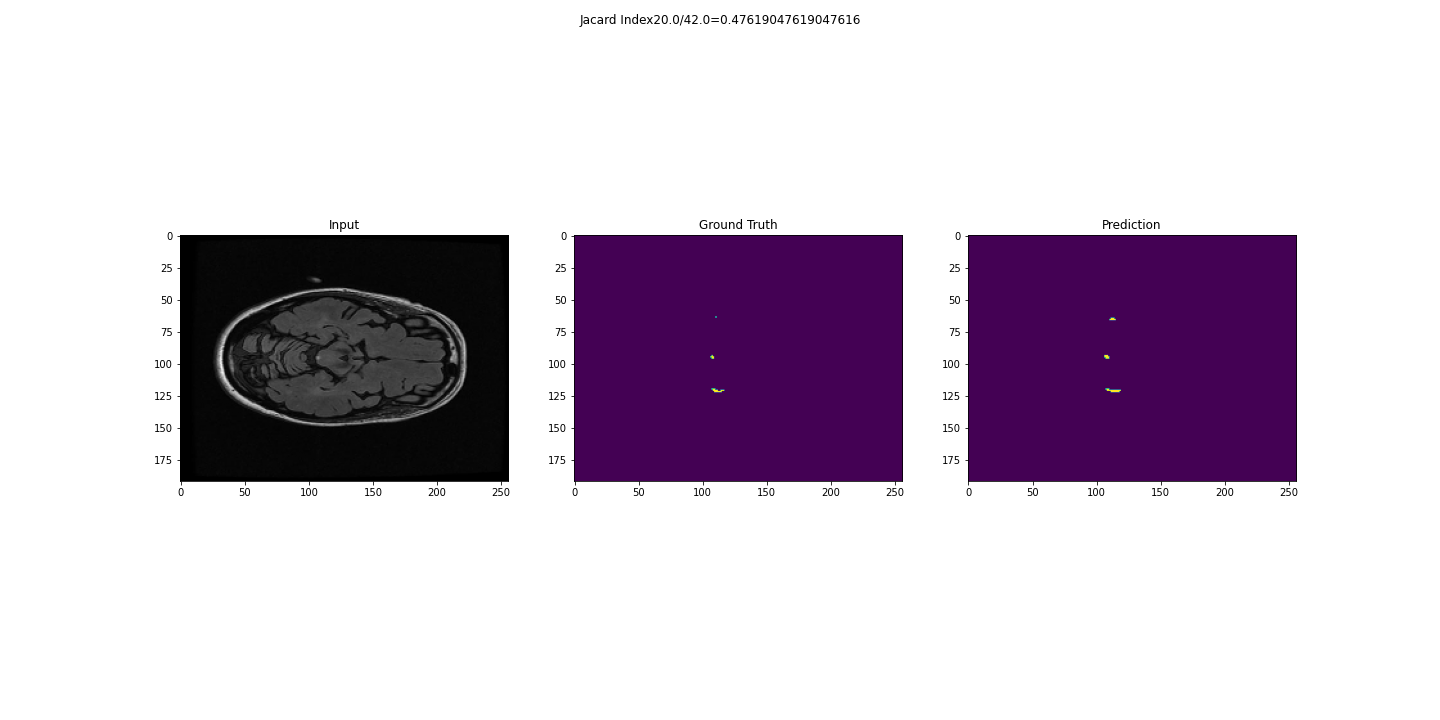

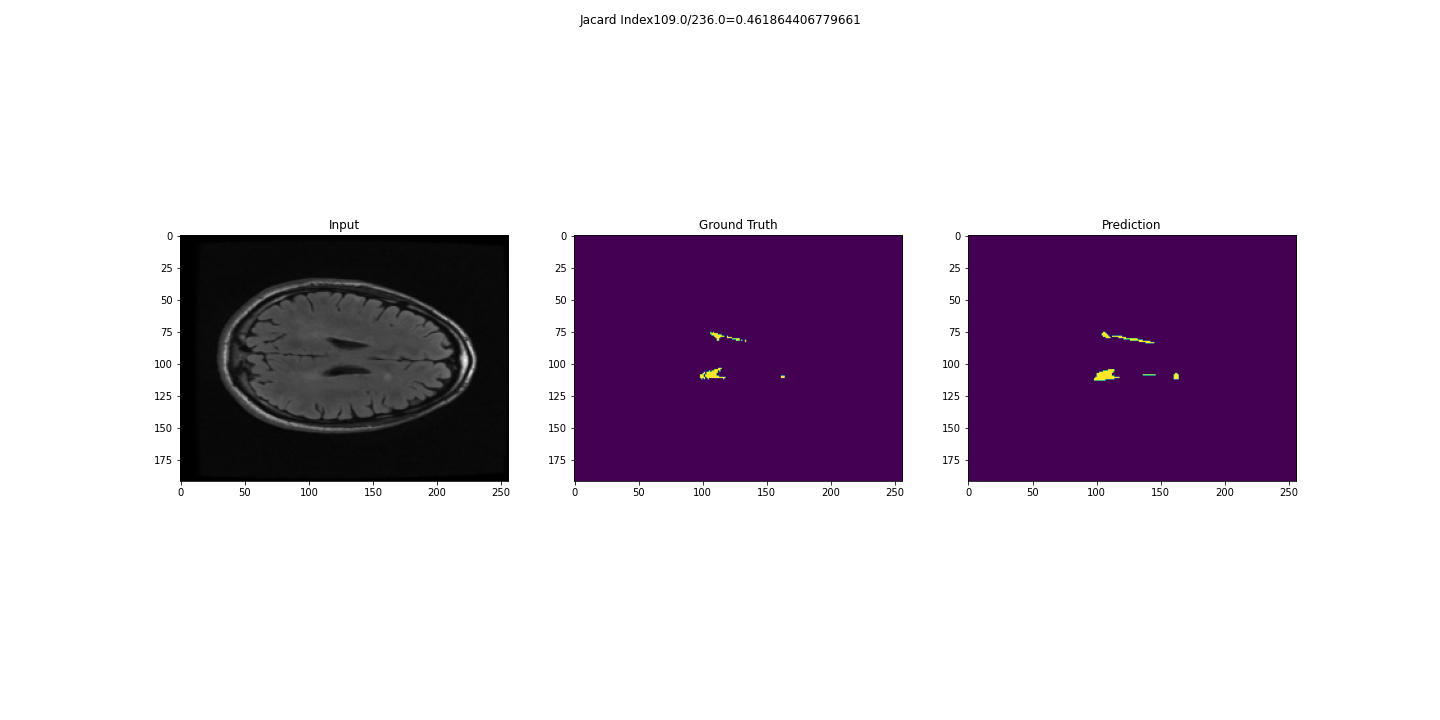

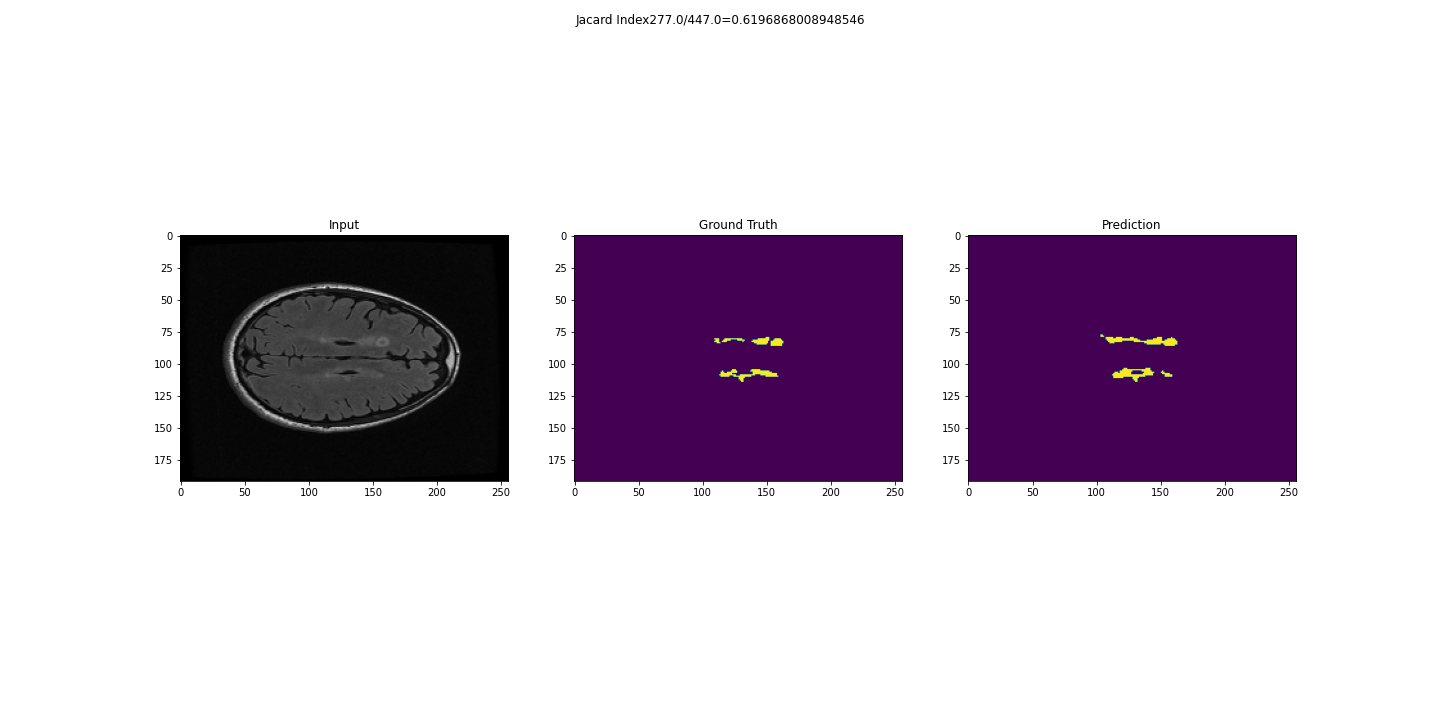

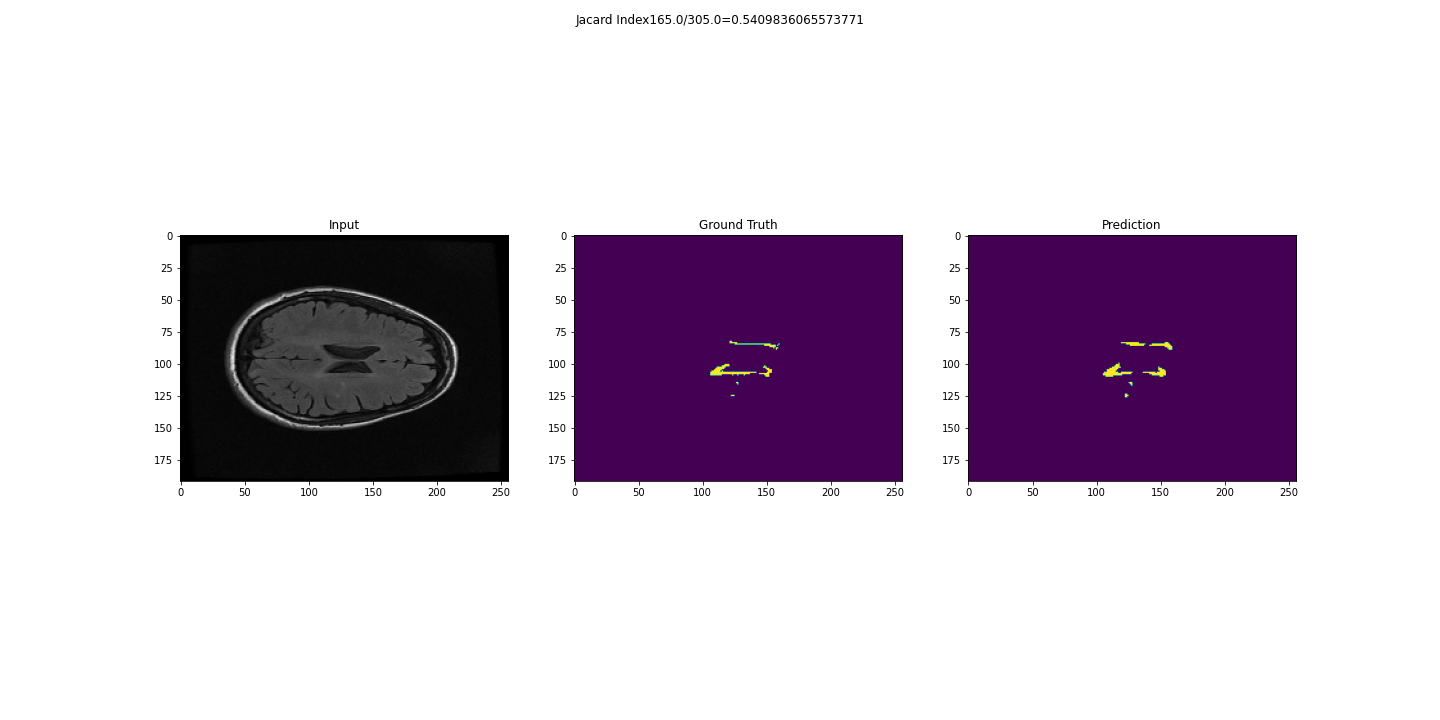

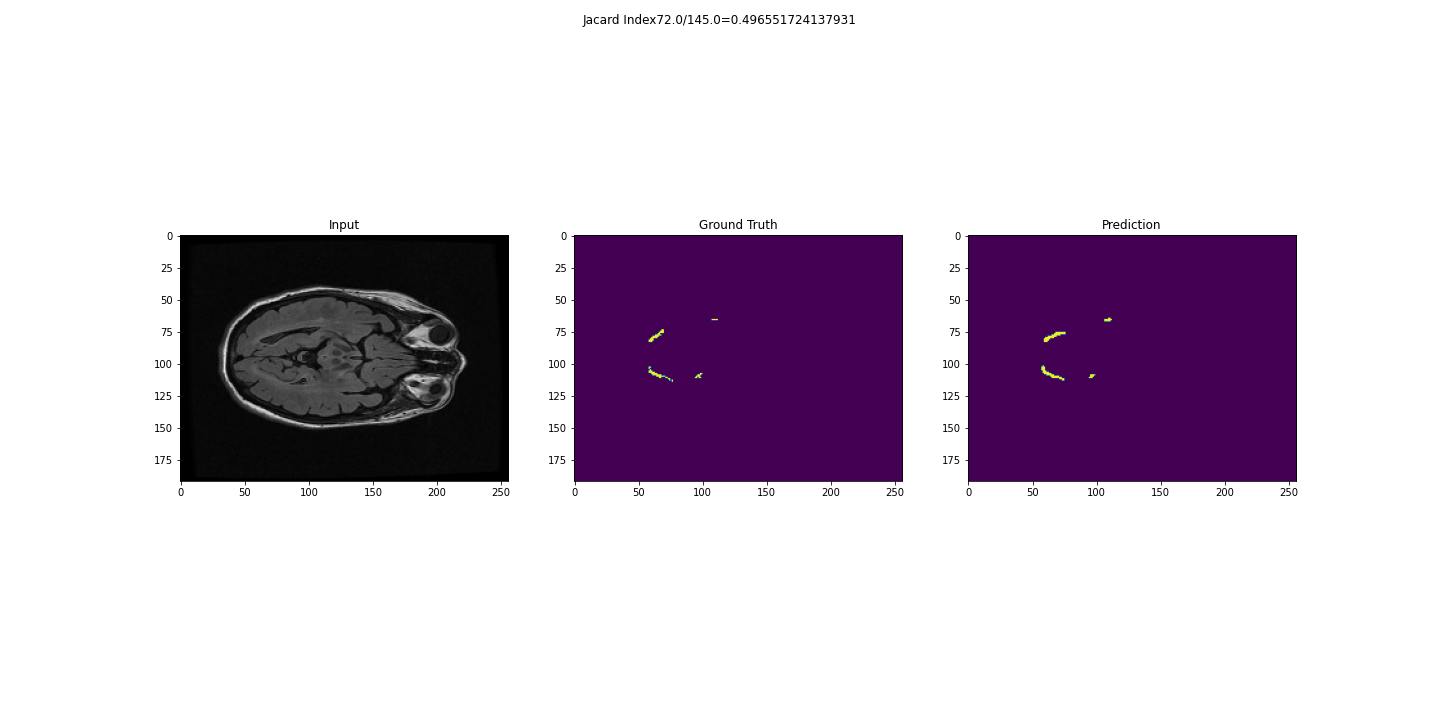

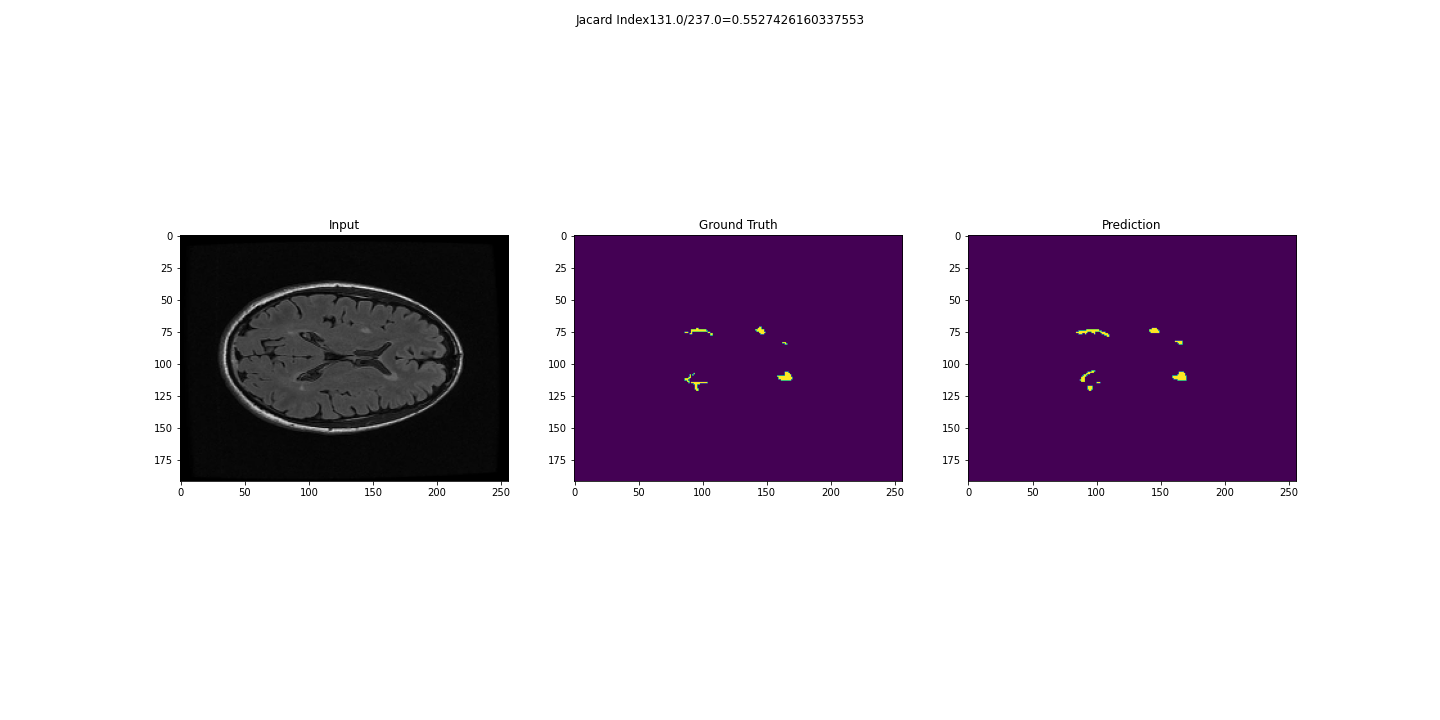

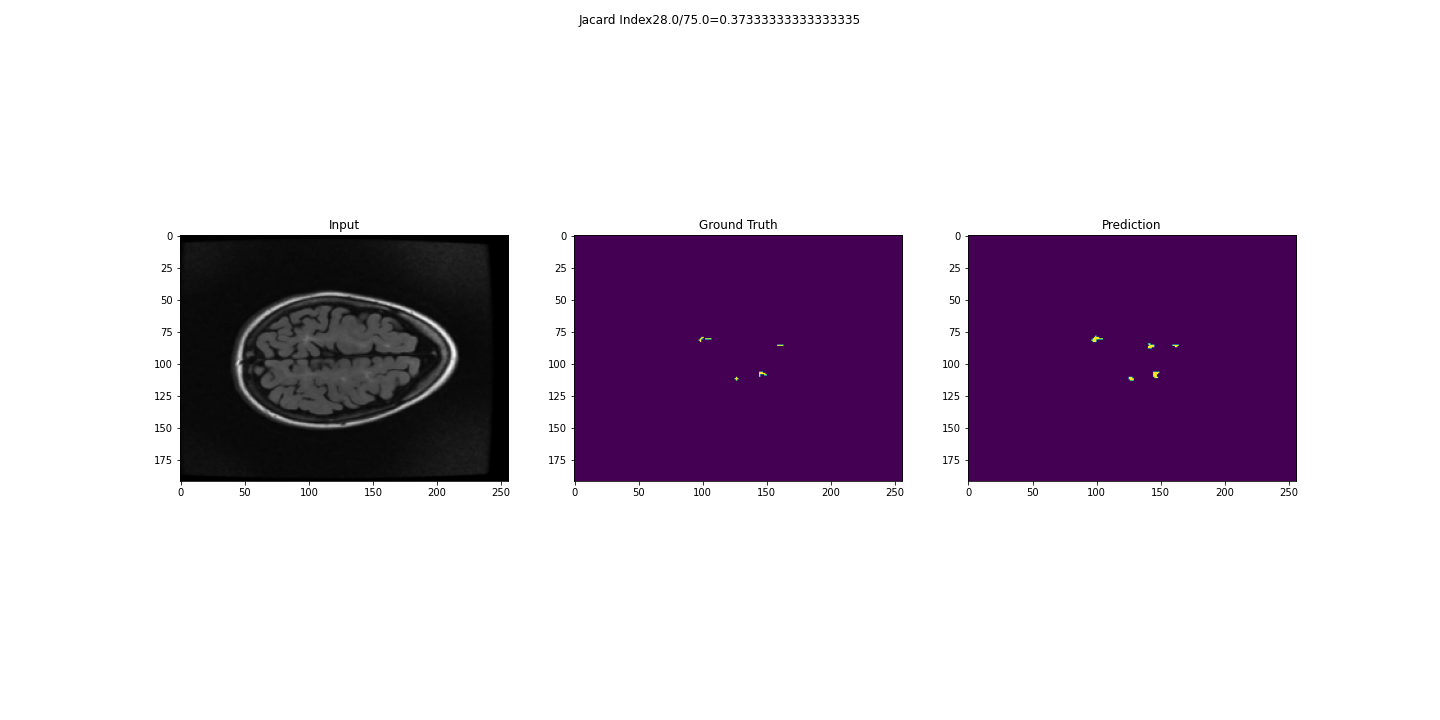

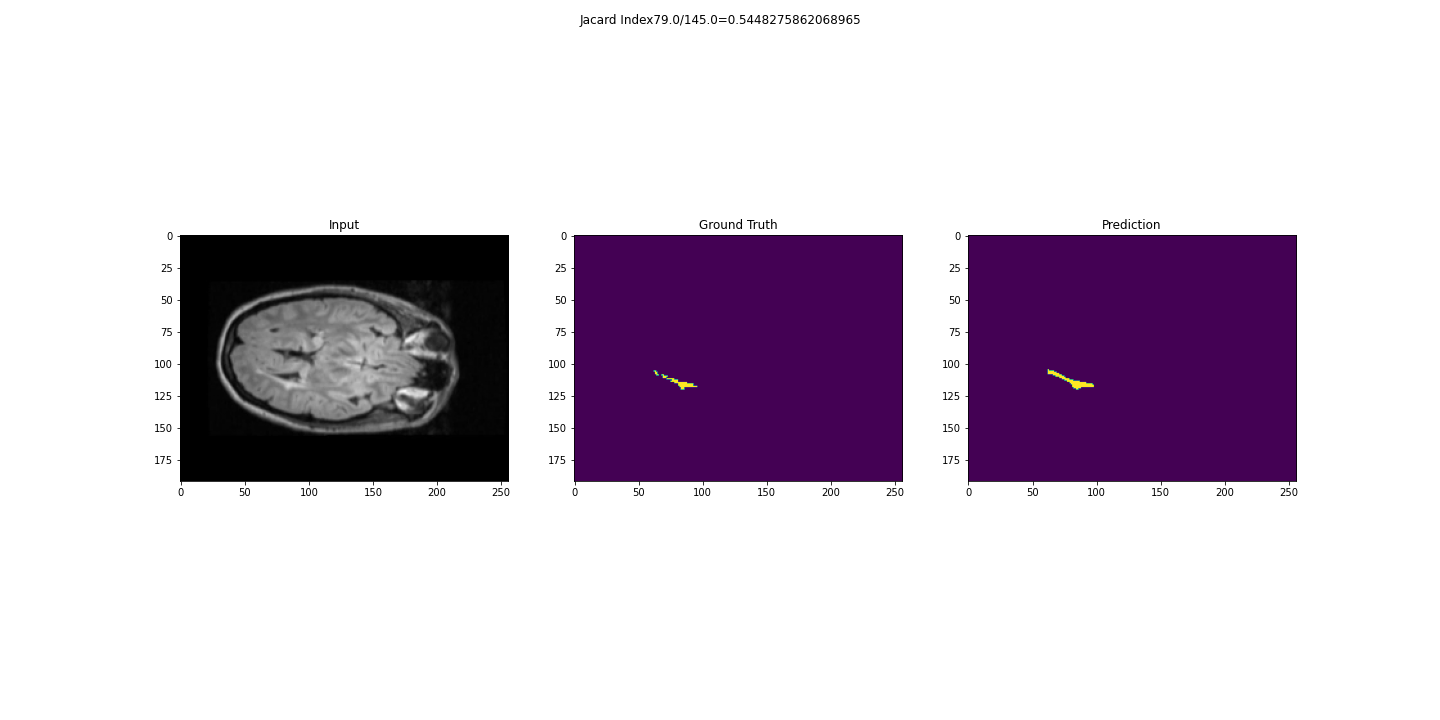

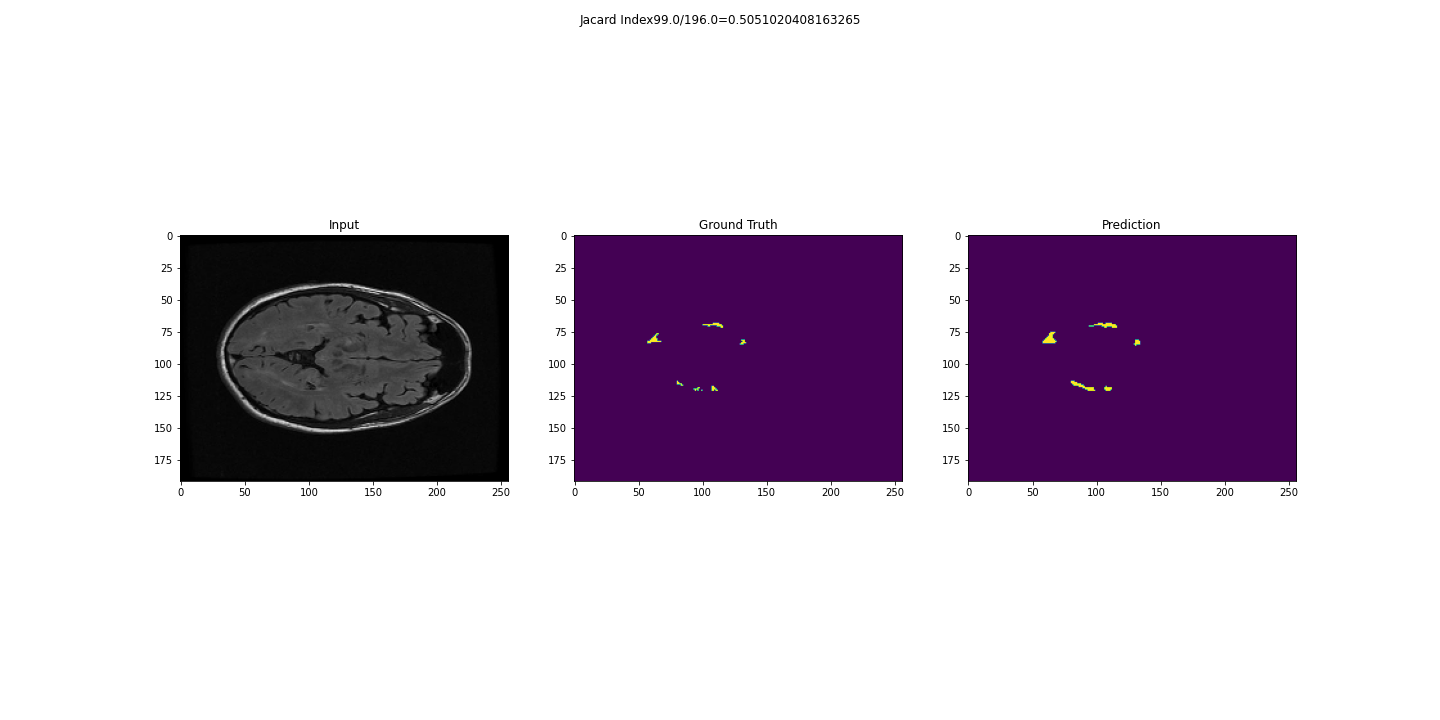

In [ ]:
import glob
images = [cv2.imread(file) for file in glob.glob("results/*.png")]
for i in images:
  cv2_imshow(i)

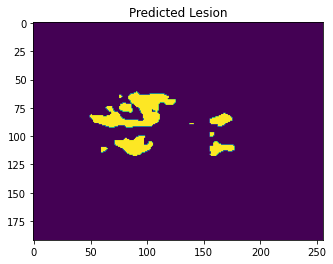

In [ ]:
single_picture_prediction = model.predict(np.array([X_test[55],]))
single_picture_prediction = np.round(single_picture_prediction, 0)
plt.title('Predicted Lesion')
plt.imshow(single_picture_prediction.reshape(single_picture_prediction.shape[1], single_picture_prediction.shape[2]))

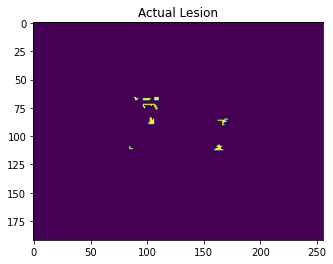

In [ ]:
ground_truth = Y_test[55]
plt.title('Actual Lesion')
plt.imshow(ground_truth.reshape(ground_truth.shape[0], ground_truth.shape[1]))

In [ ]:
#load pretrained model
trained_model = model_from_json(open('/content/drive/MyDrive/DC Unet/models/modelP.json').read())
trained_model.load_weights(os.path.join(os.path.dirname('/content/drive/MyDrive/DC Unet/models/modelP.json'), 'modelWeights.h5'))

In [ ]:
trained_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_225 (Conv2D)             (None, 192, 256, 8)  216         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_228 (Conv2D)             (None, 192, 256, 8)  216         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_336 (BatchN (None, 192, 256, 8)  24          conv2d_225[0][0]                 
____________________________________________________________________________________________

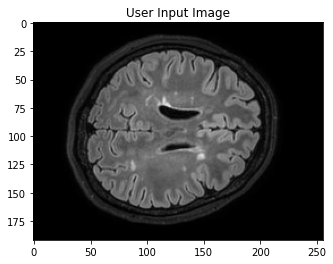

In [ ]:
user_image = cv2.imread('/content/drive/MyDrive/DC Unet/User Tests/userTest1.jpg')

plt.title('User Input Image')
plt.imshow(cv2.resize(user_image, (256, 192)))

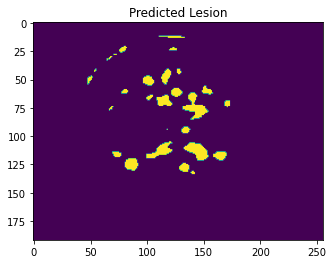

In [ ]:
image = cv2.resize(user_image,  (256, 192), interpolation = cv2.INTER_CUBIC)
image  = image/255
# image = np.round(image, 0)
single_picture_prediction = trained_model.predict(np.array([image, ]))
single_picture_prediction = np.round(single_picture_prediction, 0)

plt.title('Predicted Lesion')
plt.imshow(single_picture_prediction.reshape(single_picture_prediction.shape[1], single_picture_prediction.shape[2]))